<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/ellenmatt_lab1/Lab1/ellenmatt_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

The domain was changed and the mesh refined around the circle in the domain. When the inf-sup condition is fulfilled, the solution was stable but when equal order interpolation was applied, the pressure became unstable. This was solved with Brezzi-Pitkäranta stabilization.

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se
# test

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v)
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q)
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$.

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero.

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces,
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition.


# **Method**

**Define domain and mesh**
1. The domain is changed to have one circular hole at the center of the channel.
2. The mesh is locally refined once in a circle of radius 1 centered at the circular hole.

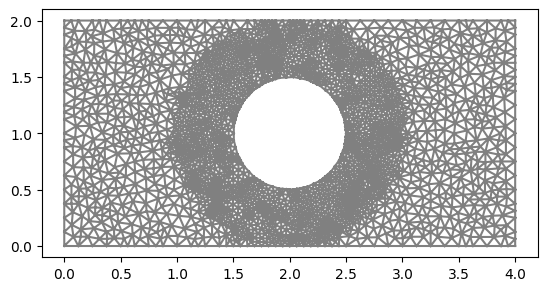

In [3]:
# Define rectangular domain
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5,0.5*H),0.2), resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(2.0,0.5*H),0.5), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(2.0, 1.0)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**
3. Changing from Taylor-Hood mixed element to equal order interpolation of velocity and pressure will cause results to be unstable.

In [ ]:
# Generate mixed finite element spaces (for velocity and pressure)
# Taylor-Hood
# VE = VectorElement("CG", mesh.ufl_cell(), 2)
# QE = FiniteElement("CG", mesh.ufl_cell(), 1)

# Equal order interpolation
VE = VectorElement("CG", mesh.ufl_cell(), 1)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)

WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

**Define boundary conditions**

In [5]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**
5. Adding a term we can stabilize the problem (Brezzi-Pitkäranta)

In [ ]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
# residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx +
#             gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

alpha = 1.0*h*h
# 5. Stabilization using Brezzi-Pitkäranta
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + alpha*inner(grad(p), grad(q))*dx +
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system
solve(residual == 0, w)

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_82a53c44eef9856bb7c50f989a687f5eca40ef43

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0308623 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00424576 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0166276 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00800133 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0272636 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00560832 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0202973 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_48383281cc8e18f1d4a8cfbf546e682d4bf76281

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_30]'
  Unique elements:           'Vector<2 x CG1(?,?)>, Mixed<Vector<2 x CG1(?,?)>, CG1(
                             ?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, Mixed<Vector<2 x CG1(?,?)>, CG1(
                             ?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_397a3d8604bfc8dc156d3239f090fbd302bbd7dd

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0299251 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0912654 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e60a432166f66faa9cd5096f9105cba41287be48

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0364633 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_876664ff3114e40089a7ef24dc58e785843465a5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_30]'
  Unique elements:           'CG1(?,?), Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 

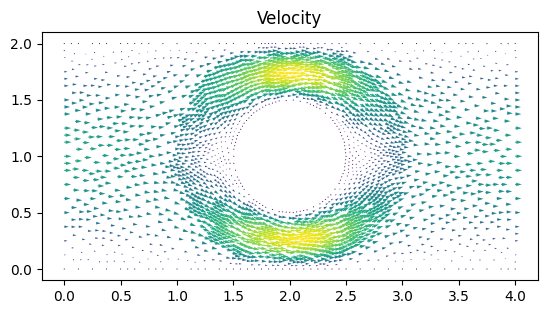

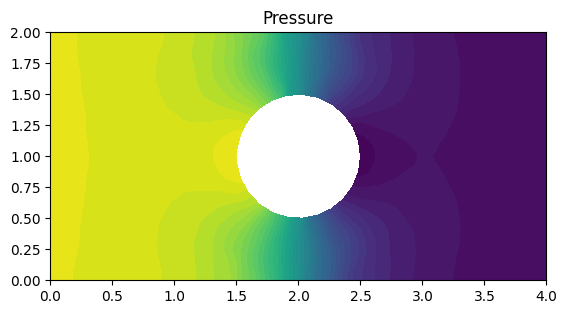

In [7]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
plt.figure()
plot(u1, title="Velocity")

plt.figure()
plot(p1, title="Pressure")

plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected.  

It can be seen that the solution is stable for the Taylor-Hood elements, but when applying piecewise linear approximation of both velocity and pressure, the pressure becomes unstable. This can be seen in he pressure plot, where the pressure looks unphysical.

If we add the term \alpha\*inner(grad(p), grad(q))\*dx, alpha = 1.0\*h\*h, to the residual, we get stability for equal order interpolation (Brezzi-Pitkäranta stabilization).